In [1]:
import numpy as np
import pandas as pd
import numpy.ma as ma
import h5py
import scipy.io
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
from sklearn.preprocessing import StandardScaler
from numba import njit
from sklearn import linear_model
from sklearn.metrics import r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.stats import pearsonr, bootstrap, BootstrapMethod
from statsmodels.stats.multitest import multipletests

# Data loading

In [31]:
marker_labels = np.load('marker_labels.npy')
marker_labels[0] = 'C7' #rename marker label
n_markers = len(marker_labels)

clusters = np.array([1,1,1,2,2,2,2,3,4,3,4,5,5,6,6,5,5,6,6])

for kc in np.unique(clusters):
    print( marker_labels[clusters==kc])

['C7' 'MA Shoulder' 'LA Shoulder']
['MA-ASI' 'MA-PSI' 'LA-ASI' 'LA-PSI']
['MA Elbow' 'MA Hand']
['LA Elbow' 'LA Hand']
['MA Knee' 'MA Ankle' 'MA Calc' 'MA Toe']
['LA Knee' 'LA Ankle' 'LA Calc' 'LA Toe']


In [3]:
# Data extraction - correlation metrics
f=h5py.File('corr_matrices_3planes.h5','r')
labels = list(f.keys())
C_a_subj_cond=[]
subj_cond_labels=[]
for kl,l in enumerate(labels):
    fc = f[l]
    C_a = np.array(fc['C_a_trials'])
    C_a[:,np.arange(n_markers),np.arange(n_markers),:]=0
    C_a_subj_cond.append(C_a)
    subj_cond_labels.append(l.split(';'))
    
f.close()
subj_cond_labels=np.array(subj_cond_labels)

In [4]:
# Whole body  aggregation

cwb = []
# Define cluster sets 
cluster_sets = [[1,2,3,4,5,6]]

# Get indices 
indices_clusters = [np.concatenate([np.where(clusters == c)[0] for c in clist]) 
                    for clist in cluster_sets]

# Loop over cluster sets
for idx, idx_cluster in enumerate(indices_clusters):
    cwb_cond_trial = []
    for k in range(len(C_a_subj_cond)):
        cwb_trial = []
        for i in range(len(C_a_subj_cond[k])):
            submat = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[idx_cluster, :][:, idx_cluster]
            cwbmean = np.triu(submat, k=1).mean()
            cwb_trial.append(cwbmean) 
        cwb_cond_trial.append(np.hstack(cwb_trial).mean())
    
    cwb.append(np.hstack(cwb_cond_trial))

var_wb = list()
var_wb.append('Whole body')

Xwb = np.array(cwb).T

In [5]:
# Segments definition

indices_clusters=[]
for km in np.unique(clusters):
    indices_clusters.append(np.where(clusters==km)[0])

In [6]:
# Segment pairs

cpairs=[]
var_labels=[]

for kc1 in range(len(indices_clusters)):
    for kc2 in range(kc1+1,len(indices_clusters)):
        c_cond_trial = []
        for k in range(len(C_a_subj_cond)):
            c_trial=[]
            for i in range(len(C_a_subj_cond[k])):
                cmean = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[indices_clusters[kc1],:][:,indices_clusters[kc2]].mean()
                c_trial.append(cmean)
            c_cond_trial.append(np.hstack(c_trial).mean())  
        cpairs.append(np.hstack(c_cond_trial))
        var_labels.append([kc1,kc2])

print(var_labels)

var_short = list()
var_short.append('Trunk-Pelvis')
var_short.append('Trunk-MA UL')
var_short.append('Trunk-LA UL')
var_short.append('Trunk-MA LL')
var_short.append('Trunk-LA LL')
var_short.append('Pelvis-MA UL')
var_short.append('Pelvis-LA UL')
var_short.append('Pelvis-MA LL')
var_short.append('Pelvis-LA LL')
var_short.append('MA UL-LA UL')
var_short.append('MA UL-MA LL')
var_short.append('MA UL-LA LL')
var_short.append('LA UL-MA LL')
var_short.append('LA UL-LA LL')
var_short.append('MA LL-LA LL')

Xps = np.array(cpairs).T

[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]


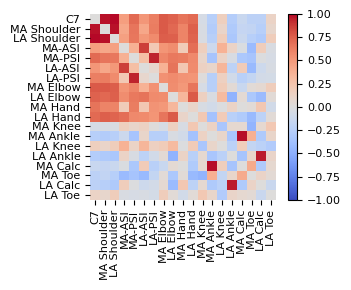

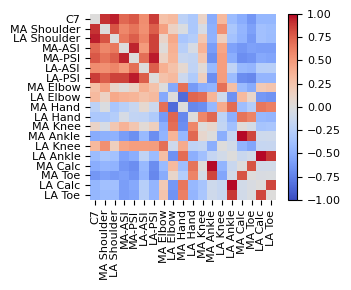

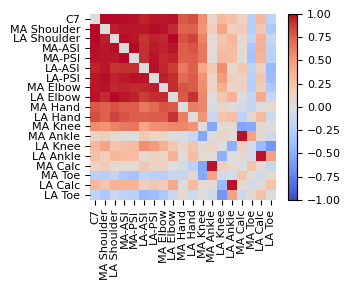

In [7]:
## Data visualization

for kd in range(3):
    plt.figure(figsize=(4, 3))  
    im = plt.imshow(C_a_subj_cond[0][0][:,:,kd],vmax=1,vmin=-1,cmap='coolwarm', interpolation='nearest')
    # --- Colorbar ---
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    # --- Axis labels ---
    plt.xticks(np.arange(len(marker_labels)), marker_labels, rotation=90, fontsize=8)
    plt.yticks(np.arange(len(marker_labels)), marker_labels, rotation=0, fontsize=8)
    
    # --- Grid & frame styling ---
    plt.gca().set_aspect('equal', adjustable='box')  # make squares actually square
    sns.despine(left=True, bottom=True)
    plt.grid(False)
    # plt.title("OFF DOPA", fontsize=9, fontweight='normal', pad=2)
    # --- Optional title (minimal style for journals) ---
    # plt.title("Coarse Connectivity Matrix", fontsize=10, pad=5)
    
    # --- Tight layout for export ---
    plt.tight_layout()
    os.makedirs('Figures/Main/Figure 1', exist_ok=True)
    plt.savefig(f"Figures/Main/Figure 1/Subpane 1B_C_example_{kd}.png", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
    plt.show()

In [ ]:
import seaborn as sns

a = np.abs(C_a_subj_cond[0][0]).mean(axis=2)

plt.figure(figsize=(4, 3))  # increase dpi for crisp journal figures

# --- Plot ---
im = plt.imshow(a, vmin=0, vmax=1, cmap='viridis', interpolation='nearest')

# --- Colorbar ---
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Mean |Correlation|", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# --- Axis labels ---
plt.xticks(np.arange(len(a)), marker_labels, rotation=90, fontsize=8)
plt.yticks(np.arange(len(a)), marker_labels, rotation=0, fontsize=8)

# --- Grid & frame styling ---
plt.gca().set_aspect('equal', adjustable='box')  # make squares actually square
sns.despine(left=True, bottom=True)
plt.grid(False)
# plt.title("OFF DOPA", fontsize=9, fontweight='normal', pad=2)
# --- Optional title (minimal style for journals) ---
# plt.title("Coarse Connectivity Matrix", fontsize=10, pad=5)

# --- Tight layout for export ---
plt.tight_layout()
os.makedirs('Figures/Main/Figure 1', exist_ok=True)
plt.savefig(f"Figures/Main/Figure 1/Subpane 1C_MAV_matrix_example.png", 
    dpi=1000, bbox_inches="tight", facecolor = 'white')
   
plt.show()

In [11]:
# Load clinical data

file_path = '_df_clinical.xlsx'  # Update if needed
xls = pd.ExcelFile(file_path)
df = xls.parse(xls.sheet_names[0])
vars_clinical = [col for col in df.columns if col not in ['Participant','Condition']]
clinical_data = {var: df[var].values for var in vars_clinical}
lookup_clinical_data = np.column_stack((df['Condition'],df['Participant']))
clinical_data_fog = clinical_data[vars_clinical[-1]]
clinical_data_updrs = clinical_data[vars_clinical[2]]
clinical_data_gabs = clinical_data[vars_clinical[-2]]

In [12]:
parts_pre = np.unique(subj_cond_labels[:,1][subj_cond_labels[:,0]=='OFF DOPA'])
print(parts_pre)

['PD01' 'PD02' 'PD03' 'PD05' 'PD07' 'PD08' 'PD09' 'PD10' 'PD11' 'PD12'
 'PD13' 'PD14' 'PD15' 'PD16' 'PD17' 'PD18']


In [13]:
# Variables initialization

Xwb_on_scores= np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_off_scores= np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_on_dbs_scores = np.zeros((len(parts_pre),Xwb.shape[1]))
Xwb_off_dbs_scores = np.zeros((len(parts_pre),Xwb.shape[1]))

Xp_on_scores= np.zeros((len(parts_pre),Xps.shape[1]))
Xp_off_scores= np.zeros((len(parts_pre),Xps.shape[1]))
Xp_on_dbs_scores = np.zeros((len(parts_pre),Xps.shape[1]))
Xp_off_dbs_scores = np.zeros((len(parts_pre),Xps.shape[1]))

fog_post = np.zeros(len(parts_pre))
fog_pre = np.zeros(len(parts_pre))
updrs_on = np.zeros(len(parts_pre))
updrs_off = np.zeros(len(parts_pre))
updrs_dbs = np.zeros(len(parts_pre))
gabs_on = np.zeros(len(parts_pre))
gabs_off = np.zeros(len(parts_pre))
gabs_dbs = np.zeros(len(parts_pre))
updrs_off_dbs = np.zeros(len(parts_pre))
gabs_off_dbs = np.zeros(len(parts_pre))

for kp,part in enumerate(parts_pre):
    sel_kin_on = np.all(subj_cond_labels==['ON DOPA',part],axis=1)
    Xwb_on_scores[kp] = Xwb[sel_kin_on]
    Xp_on_scores[kp] = Xps[sel_kin_on]

    sel_clin_on = np.all(lookup_clinical_data==['ON DOPA',part],axis=1)
    updrs_on[kp] = clinical_data_updrs[sel_clin_on][0]
    gabs_on[kp] = clinical_data_gabs[sel_clin_on][0]

    sel_kin_off = np.all(subj_cond_labels==['OFF DOPA',part],axis=1)
    Xwb_off_scores[kp] = Xwb[sel_kin_off]
    Xp_off_scores[kp] = Xps[sel_kin_off]

    sel_clin_off = np.all(lookup_clinical_data==['OFF DOPA',part],axis=1)
    fog_pre[kp] = clinical_data_fog[sel_clin_off][0]
    updrs_off[kp] = clinical_data_updrs[sel_clin_off][0]
    gabs_off[kp] = clinical_data_gabs[sel_clin_off][0]

    sel_kin_on_dbs = np.all(subj_cond_labels==['ON DBS',part],axis=1)
    Xwb_on_dbs_scores[kp] = Xwb[sel_kin_on_dbs]
    Xp_on_dbs_scores[kp] = Xps[sel_kin_on_dbs]
    
    sel_clin_dbs = np.all(lookup_clinical_data==['ON DBS',part],axis=1)
    updrs_dbs[kp] = clinical_data_updrs[sel_clin_dbs][0]
    gabs_dbs[kp] = clinical_data_gabs[sel_clin_dbs][0]

    sel_kin_off_dbs = np.all(subj_cond_labels==['OFF DBS',part],axis=1)
    Xwb_off_dbs_scores[kp] = Xwb[sel_kin_off_dbs]
    Xp_off_dbs_scores[kp] = Xps[sel_kin_off_dbs]

    sel_clin_off_dbs = np.all(lookup_clinical_data==['OFF DBS',part],axis=1)
    fog_post[kp] = clinical_data_fog[sel_clin_off_dbs][0]
    updrs_off_dbs[kp] = clinical_data_updrs[sel_clin_off_dbs][0]
    gabs_off_dbs[kp] = clinical_data_gabs[sel_clin_off_dbs][0]

# Group analysis

In [14]:
def permutation_test(x, y, n_permutations=10000, paired=True, seed=None):
    """
    Permutation test for paired or independent samples.
    
    Parameters
    ----------
    x : array-like
        First sample
    y : array-like
        Second sample
    n_permutations : int, default=10000
        Number of permutations to perform
    paired : bool, default=True
        If True, perform paired test. If False, perform independent samples test
    seed : int, optional
        Random seed for reproducibility
    
    Returns
    -------
    float or tuple
        P-value, or (p-value, permutation_distribution) if return_dist=True
    """
    rng = np.random.default_rng(seed)
    if paired:
        observed = np.mean(x - y)
    else:
        observed = np.mean(x) - np.mean(y)
    
    perm_diffs = np.zeros(n_permutations)
    for i in range(n_permutations):
        if paired:
            signs = rng.choice([1, -1], size=len(x))
            perm_diffs[i] = np.mean((x - y) * signs)
        else:
            pooled = np.hstack([x, y])
            rng.shuffle(pooled)
            
            perm_diffs[i] = np.mean(pooled[:len(x)]) - np.mean(pooled[len(x):])
    
    return np.mean(np.abs(perm_diffs) >= np.abs(observed))


In [ ]:
def get_sigstar(p):
    """
    Return significance stars based on p-value.
    
    Parameters
    ----------
    p : float
        P-value to evaluate
    thresholds : list of float, optional
        Custom significance thresholds in descending order.
        Default: [0.001, 0.01, 0.05]
    symbols : list of str, optional
        Custom symbols corresponding to thresholds.
        Default: ['***', '**', '*']
    
    Returns
    -------
    str
        Significance symbol(s) or empty string if not significant
    """
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

[(0, 1, np.float64(0.5538)), (2, 3, np.float64(0.3776)), (1, 3, np.float64(0.5538)), (0, 3, np.float64(0.412))]


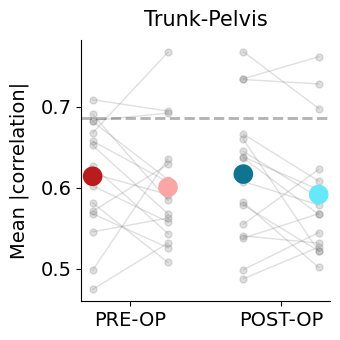

[(0, 1, np.float64(0.0)), (2, 3, np.float64(0.4725)), (1, 3, np.float64(0.0006)), (0, 3, np.float64(0.4497333333333333))]


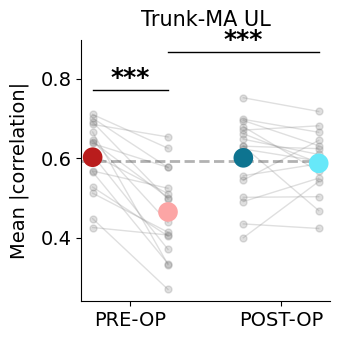

[(0, 1, np.float64(0.0008)), (2, 3, np.float64(0.4364)), (1, 3, np.float64(0.0008)), (0, 3, np.float64(0.2452))]


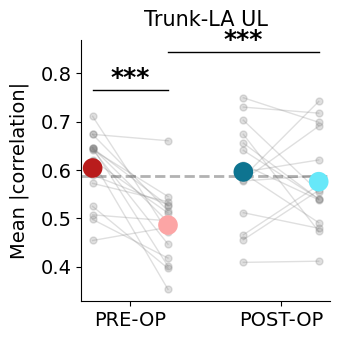

[(0, 1, np.float64(0.6233)), (2, 3, np.float64(0.6233)), (1, 3, np.float64(0.6233)), (0, 3, np.float64(0.6233))]


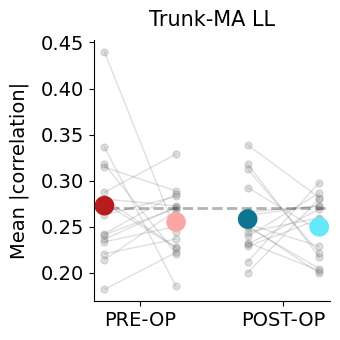

[(0, 1, np.float64(0.876)), (2, 3, np.float64(0.876)), (1, 3, np.float64(0.876)), (0, 3, np.float64(0.876))]


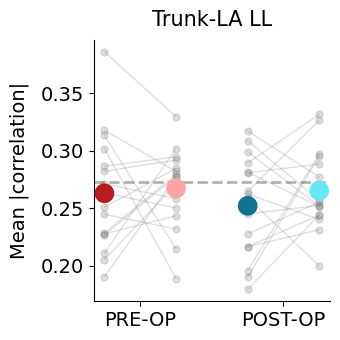

[(0, 1, np.float64(0.0004)), (2, 3, np.float64(0.11720000000000001)), (1, 3, np.float64(0.0066)), (0, 3, np.float64(0.1683))]


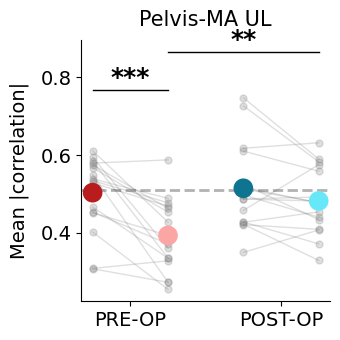

[(0, 1, np.float64(0.006)), (2, 3, np.float64(0.2239)), (1, 3, np.float64(0.006)), (0, 3, np.float64(0.12319999999999999))]


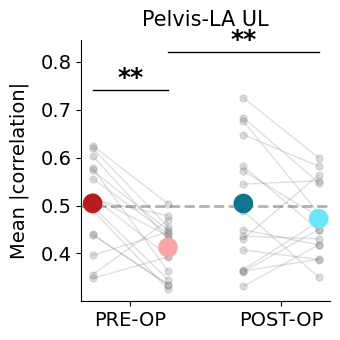

[(0, 1, np.float64(0.8603999999999999)), (2, 3, np.float64(0.8603999999999999)), (1, 3, np.float64(0.8603999999999999)), (0, 3, np.float64(0.9061))]


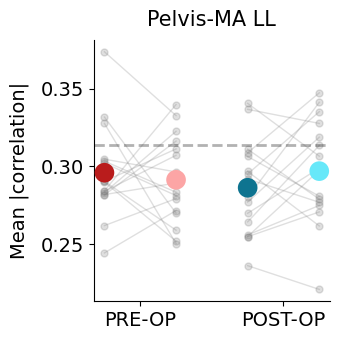

[(0, 1, np.float64(0.48666666666666664)), (2, 3, np.float64(0.48666666666666664)), (1, 3, np.float64(0.48666666666666664)), (0, 3, np.float64(0.7923))]


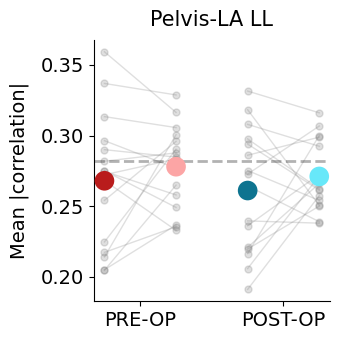

[(0, 1, np.float64(0.0228)), (2, 3, np.float64(0.028133333333333333)), (1, 3, np.float64(0.0088)), (0, 3, np.float64(0.6297))]


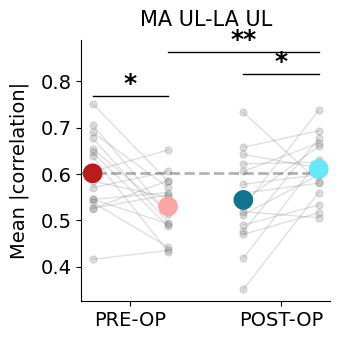

[(0, 1, np.float64(0.462)), (2, 3, np.float64(0.4882666666666667)), (1, 3, np.float64(0.5156)), (0, 3, np.float64(0.4882666666666667))]


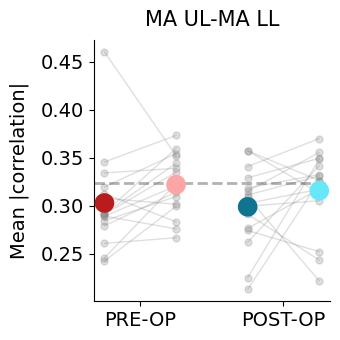

[(0, 1, np.float64(0.0128)), (2, 3, np.float64(0.006)), (1, 3, np.float64(0.2906)), (0, 3, np.float64(0.13693333333333332))]


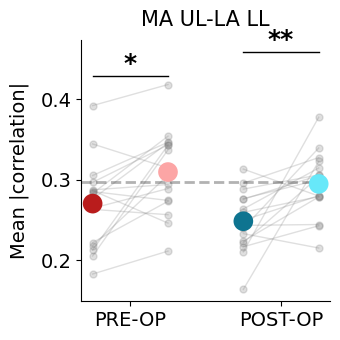

[(0, 1, np.float64(0.0048)), (2, 3, np.float64(0.08946666666666668)), (1, 3, np.float64(0.0054)), (0, 3, np.float64(0.5218))]


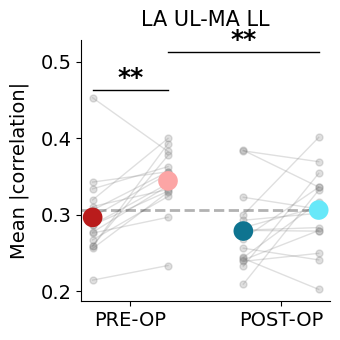

[(0, 1, np.float64(0.0704)), (2, 3, np.float64(0.39599999999999996)), (1, 3, np.float64(0.39599999999999996)), (0, 3, np.float64(0.4333))]


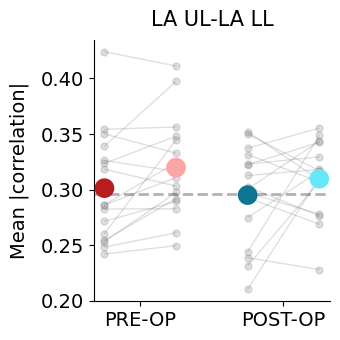

[(0, 1, np.float64(0.0176)), (2, 3, np.float64(0.188)), (1, 3, np.float64(0.4355)), (0, 3, np.float64(0.2156))]


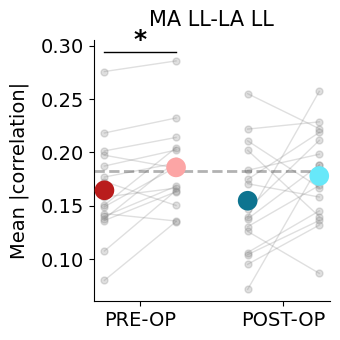

In [23]:
# --- Define your color palette ---
palette = ['#b91c1c','#fca5a5','#0e7490','#67e8f9']  # light red, dark red, dark teal, light teal

for kd in range(len(var_short)): 
    # --- Prepare data ---
    data = np.vstack([
        Xp_off_scores[:, kd],     # 0: OFF
        Xp_on_scores[:, kd],      # 1: ON
        Xp_off_dbs_scores[:, kd], # 2: DBS OFF
        Xp_on_dbs_scores[:, kd]   # 3: DBS ON
    ])
    n_conditions, n_subjects = data.shape

    # --- HC mean and SEM ---
    hc_values = Xps[subj_cond_labels[:,0]=='HC'][:, kd]
    hc_mean = hc_values.mean()
    hc_sem = np.std(hc_values, ddof=1) / np.sqrt(hc_values.size)

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    x = np.arange(n_conditions)

    # --- Within-subject paired lines ---
    for subj in range(n_subjects):
        ax.plot([0, 1], data[[0, 1], subj], c='gray', alpha=0.25, lw=1, marker='o', markersize=5)
        ax.plot([2, 3], data[[2, 3], subj], c='gray', alpha=0.25, lw=1, marker='o', markersize=5)

    # --- Mean values (colored dots) ---
    mean_vals = data.mean(axis=1)
    for xi, (mean_y, c) in enumerate(zip(mean_vals, palette)):
        ax.scatter(xi, mean_y, marker='o', s=200, color=c, edgecolor='none', zorder=3)

    # --- HC reference (shaded band) ---
    # ax.axhspan(hc_mean - hc_sem, hc_mean + hc_sem, color='black', alpha=0.2, zorder=0)
    ax.axhline(hc_mean, color='black', linestyle='--', alpha=0.3, lw=2)

    # --- X labels ---
    ax.set_xticks([0.5, 2.5])
    ax.set_xticklabels(['PRE-OP', 'POST-OP'], fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # --- Remove top/right spines for clarity ---
    sns.despine(ax=ax)

    # --- Run permutation tests (as before) ---
    p_off_on  = permutation_test(Xp_off_scores[:, kd], Xp_on_scores[:, kd], paired=True)
    p_off_dbs = permutation_test(Xp_off_dbs_scores[:, kd], Xp_on_dbs_scores[:, kd], paired=True)
    p_off_dopa_on_dbs = permutation_test(Xp_off_scores[:, kd], Xp_on_dbs_scores[:, kd], paired=True)
    p_on_dbs  = permutation_test(Xp_on_scores[:, kd], Xp_on_dbs_scores[:, kd], paired=True)
    
    p_double_off = permutation_test(Xp_off_scores[:, kd], Xp_off_dbs_scores[:, kd], paired=True)
    p_on_dopa_off_dbs  = permutation_test(Xp_on_scores[:, kd], Xp_off_dbs_scores[:, kd], paired=True)

    # --- FDR correction ---
    raw_pvals = [p_off_on, p_off_dbs, p_on_dbs, p_off_dopa_on_dbs] #, p_double_off, p_on_dopa_off_dbs
    reject, pvals_fdr, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')
    p_off_on_fdr, p_off_dbs_fdr, p_on_dbs_fdr, p_off_dopa_on_dbs_fdr = pvals_fdr #, p_double_off_fdr, p_on_dopa_off_dbs_fdr

    # --- Remove spines and grid ---
    sns.despine(ax=ax)
    ax.grid(False)  # completely remove the grid background
    
    # --- Annotate significance stars ---
    y_max = data.max()
    step = (data.max() - data.min()) * 0.08
    comparisons = [
        (0, 1, p_off_on_fdr),
        # (1, 2, p_on_dopa_off_dbs_fdr),
        (2, 3, p_off_dbs_fdr),
        # (0, 2, p_double_off_fdr),
        (1, 3, p_on_dbs_fdr),
        (0, 3, p_off_dopa_on_dbs_fdr)         
    ]
    print(comparisons)
    c = .5
    for i, (x1, x2, p) in enumerate(comparisons):
        if p < 0.05:
            y = y_max + (i+1*c) * step
            c = c+.5
            ax.plot([x1, x1, x2, x2], [y, y, y, y], c='black', lw=1)
            ax.text((x1+x2)/2, y , get_sigstar(p),
                    ha='center', va='bottom', fontsize=18, fontweight='bold')

    # --- Title / label ---
    ax.set_title(var_short[kd], fontsize=15, pad=10)
    ax.set_ylabel("Mean |correlation|", fontsize=14, labelpad=8)
    
    # --- Save publication-quality figure ---
    plt.tight_layout()
    # Create directory (and parent directories if they don't exist)
    os.makedirs('Figures/Supplementary/Figure S4', exist_ok=True)
    fig.savefig(f"Figures/Supplementary/Figure S4/Coordination_{var_short[kd]}.png", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
    plt.show()

[(0, 1, np.float64(0.0948)), (2, 3, np.float64(0.6477)), (1, 3, np.float64(0.0948)), (0, 3, np.float64(0.6477))]


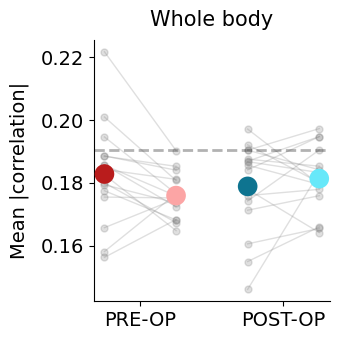

In [26]:
for kd in range(len(var_wb)): 
    # --- Prepare data ---
    data = np.vstack([
        Xwb_off_scores[:, kd],     # 0: OFF
        Xwb_on_scores[:, kd],      # 1: ON
        Xwb_off_dbs_scores[:, kd], # 2: DBS OFF
        Xwb_on_dbs_scores[:, kd]   # 3: DBS ON
    ])
    n_conditions, n_subjects = data.shape

    # --- HC mean and SEM ---
    hc_values = Xwb[subj_cond_labels[:,0]=='HC'][:, kd]
    hc_mean = hc_values.mean()
    hc_sem = np.std(hc_values, ddof=1) / np.sqrt(hc_values.size)

    # --- Create figure ---
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    x = np.arange(n_conditions)

    # --- Within-subject paired lines ---
    for subj in range(n_subjects):
        ax.plot([0, 1], data[[0, 1], subj], c='gray', alpha=0.25, lw=1, marker='o', markersize=5)
        ax.plot([2, 3], data[[2, 3], subj], c='gray', alpha=0.25, lw=1, marker='o', markersize=5)

    # --- Mean values (colored dots) ---
    mean_vals = data.mean(axis=1)
    for xi, (mean_y, c) in enumerate(zip(mean_vals, palette)):
        ax.scatter(xi, mean_y, marker='o', s=200, color=c, edgecolor='none', zorder=3)

    # --- HC reference (shaded band) ---
    # ax.axhspan(hc_mean - hc_sem, hc_mean + hc_sem, color='black', alpha=0.2, zorder=0)
    ax.axhline(hc_mean, color='black', linestyle='--', alpha=0.3, lw=2)

    # --- X labels ---
    ax.set_xticks([0.5, 2.5])
    ax.set_xticklabels(['PRE-OP', 'POST-OP'], fontsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    # --- Remove top/right spines for clarity ---
    sns.despine(ax=ax)

    # --- Run permutation tests (as before) ---
    p_off_on  = permutation_test(Xwb_off_scores[:, kd], Xwb_on_scores[:, kd], paired=True)
    p_off_dbs = permutation_test(Xwb_off_dbs_scores[:, kd], Xwb_on_dbs_scores[:, kd], paired=True)
    p_off_dopa_on_dbs = permutation_test(Xwb_off_scores[:, kd], Xwb_on_dbs_scores[:, kd], paired=True)
    p_on_dbs  = permutation_test(Xwb_on_scores[:, kd], Xwb_on_dbs_scores[:, kd], paired=True)
    
    p_double_off = permutation_test(Xwb_off_scores[:, kd], Xwb_off_dbs_scores[:, kd], paired=True)
    p_on_dopa_off_dbs  = permutation_test(Xwb_on_scores[:, kd], Xwb_off_dbs_scores[:, kd], paired=True)

    # --- FDR correction ---
    raw_pvals = [p_off_on, p_off_dbs, p_on_dbs, p_off_dopa_on_dbs] #, p_double_off, p_on_dopa_off_dbs
    reject, pvals_fdr, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')
    p_off_on_fdr, p_off_dbs_fdr, p_on_dbs_fdr, p_off_dopa_on_dbs_fdr = pvals_fdr #, p_double_off_fdr, p_on_dopa_off_dbs_fdr

    # --- Remove spines and grid ---
    sns.despine(ax=ax)
    ax.grid(False)  # completely remove the grid background
    
    # --- Annotate significance stars ---
    y_max = data.max()
    step = (data.max() - data.min()) * 0.08
    comparisons = [
        (0, 1, p_off_on_fdr),
        # (1, 2, p_on_dopa_off_dbs_fdr),
        (2, 3, p_off_dbs_fdr),
        # (0, 2, p_double_off_fdr),
        (1, 3, p_on_dbs_fdr),
        (0, 3, p_off_dopa_on_dbs_fdr)         
    ]
    print(comparisons)
    c = .5
    for i, (x1, x2, p) in enumerate(comparisons):
        if p < 0.05:
            y = y_max + (i+1*c) * step
            c = c+.5
            ax.plot([x1, x1, x2, x2], [y, y, y, y], c='black', lw=1)
            ax.text((x1+x2)/2, y , get_sigstar(p),
                    ha='center', va='bottom', fontsize=18, fontweight='bold')

    # --- Title / label ---
    ax.set_title(var_wb[kd], fontsize=15, pad=10)
    ax.set_ylabel("Mean |correlation|", fontsize=14, labelpad=8)
    
    # --- Save publication-quality figure ---
    plt.tight_layout()
    os.makedirs('Figures/Main/Figure 3', exist_ok=True)
    fig.savefig(f"Figures/Main/Figure 3/Subpane 3A_Coordination_{var_wb[kd]}.png", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
    plt.show()

# Univariate associations with clinical scores

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, bootstrap
from scipy.stats._resampling import BootstrapMethod
from statsmodels.stats.multitest import multipletests

# Setup
n_boot = 10000
rng = np.random.default_rng()
method = BootstrapMethod(method='BCa', rng=rng)

X_preop_off = np.hstack([Xp_off_scores, Xwb_off_scores])
X_preop_on = np.hstack([Xp_on_scores, Xwb_on_scores])
X_postop_off = np.hstack([Xp_off_dbs_scores, Xwb_off_dbs_scores])
X_postop_on = np.hstack([Xp_on_dbs_scores, Xwb_on_dbs_scores])

X_combined = [X_preop_off, X_preop_on, X_postop_off, X_postop_on]  
vars_coord_tot = var_short + ['Whole body']
condition_labels = ['OFF DOPA', 'ON DOPA', 'OFF DBS', 'ON DBS']

# Storage for results
n_vars = X_preop_off.shape[1]
n_conditions = len(X_combined)
correlations = np.zeros((n_conditions, n_vars))
ci_low = np.zeros((n_conditions, n_vars))
ci_high = np.zeros((n_conditions, n_vars))
pvals = np.zeros((n_conditions, n_vars))

for cond_idx, X in enumerate(X_combined):

    # Select outcome
    if cond_idx < 2:
        y = fog_pre
    else:
        y = fog_post

    for var_idx in range(n_vars):
        x = X[:, var_idx]

        # Pearson correlation
        res = pearsonr(x, y)
        r_naive = res.statistic
        ci = res.confidence_interval(confidence_level=0.95, method=method)

        correlations[cond_idx, var_idx] = r_naive
        ci_low[cond_idx, var_idx] = ci.low
        ci_high[cond_idx, var_idx] = ci.high

        # Bootstrap p-value
        rs = np.zeros(n_boot)
        for i_boot in range(n_boot):
            idx = rng.integers(0, len(y), len(y))
            rs[i_boot] = pearsonr(x[idx], y[idx]).statistic

        if r_naive > 0:
            pvals[cond_idx, var_idx] = np.mean(rs <= 0)
        else:
            pvals[cond_idx, var_idx] = np.mean(rs >= 0)

pvals_corrected = np.zeros_like(pvals)
reject = np.zeros_like(pvals, dtype=bool)

# PRE (rows 0 and 1)
pvals_pre = pvals[0:2, :].flatten()
rej_pre, pvals_pre_corr, _, _ = multipletests(pvals_pre, alpha=0.05, method='fdr_bh')
pvals_corrected[0:2, :] = pvals_pre_corr.reshape(2, n_vars)
reject[0:2, :] = rej_pre.reshape(2, n_vars)

# POST (rows 2 and 3)
pvals_post = pvals[2:4, :].flatten()
rej_post, pvals_post_corr, _, _ = multipletests(pvals_post, alpha=0.05, method='fdr_bh')
pvals_corrected[2:4, :] = pvals_post_corr.reshape(2, n_vars)
reject[2:4, :] = rej_post.reshape(2, n_vars)

# Create annotation array with significance stars
annot = np.empty_like(correlations, dtype=object)
for cond_idx in range(n_conditions):
    for var_idx in range(n_vars):
        r = correlations[cond_idx, var_idx]
        p = pvals_corrected[cond_idx, var_idx]   
        sig = get_sigstar(p)
        
        # annot[cond_idx, var_idx] = f'{r:.2f}{sig}'
        annot[cond_idx, var_idx] = f'{sig}'

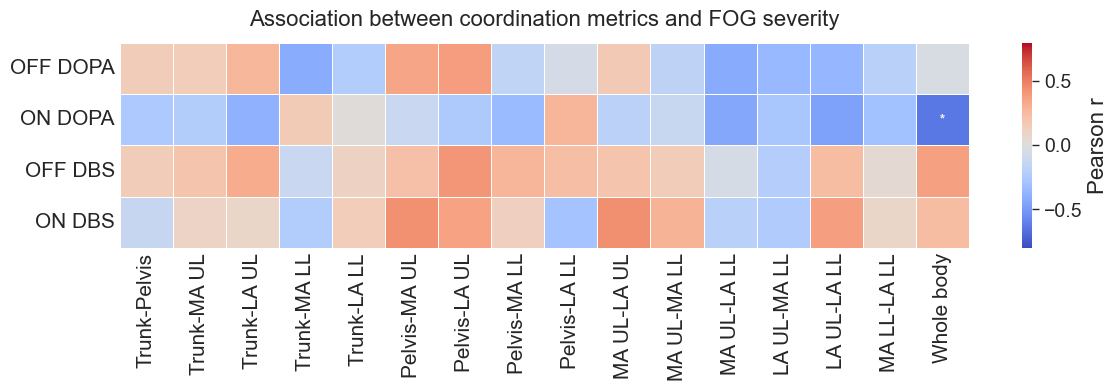

In [16]:
# Create heatmap 
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

fig, ax = plt.subplots(figsize=(12, 4))

cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(
    correlations,
    annot=annot,
    fmt="",
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": 'Pearson r', "shrink": 1},
    annot_kws={"weight": "bold"},
    vmin=-0.8, 
    vmax=0.8,
    ax=ax
)

# X-axis: coordination metrics
n = len(vars_coord_tot)
xl = np.arange(n) + 0.5
plt.xticks(xl, vars_coord_tot, fontsize=15, rotation=90, ha='center')

# Y-axis: condition labels
yl = np.arange(n_conditions) + 0.5
plt.yticks(yl, condition_labels, fontsize=15, rotation=0)
plt.tick_params(axis='both', which='both', length=0)

# Title
plt.title("Association between coordination metrics and FOG severity", fontsize=16, pad=12)

# Remove grid for cleaner look
plt.grid(False)

# Tight layout for publication-quality
plt.tight_layout()

os.makedirs('Figures/Supplementary/Figure S5', exist_ok=True)
fig.savefig(f"Figures/Supplementary/Figure S5/Subpane 5A_heatmap_FOG_coord.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')

plt.show()

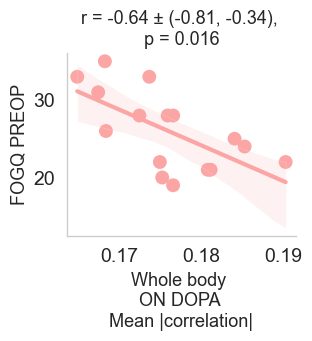

In [29]:
## Scatter plot of the significant one

sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

plt.figure(figsize=(3.2,3.5))

x = Xwb_on_scores 
y = np.vstack([fog_pre])

plt.scatter(x=x, y=y, c='#fca5a5', s=100, edgecolor='none')

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# Add regression line (not color-coded)
sns.regplot(x=x, y=y, scatter=False, ci=95, line_kws={"color":"#fca5a5", "lw": 3})

# Correlation

plt.title(f"r = {correlations[1,X_preop_on.shape[1]-1]:.2f} ± ({ci_low[1,X_preop_on.shape[1]-1]:.2f}, {ci_high[1,X_preop_on.shape[1]-1]:.2f}), \np = {pvals_corrected[1,X_preop_on.shape[1]-1]:.3f}", fontsize = 13)

plt.ylabel("FOGQ PREOP", fontsize = 13)
plt.xlabel(f"Whole body \nON DOPA \nMean |correlation|", fontsize = 13)

sns.despine(right=True, top=True)
plt.tight_layout()
plt.grid(False)
os.makedirs('Figures/Main/Figure 3', exist_ok=True)
plt.savefig(f"Figures/Main/Figure 3/Subpane 3B_scatter_WBON_FOGPREOP.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

# UPDRS LMER

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import r2_score
from scipy.stats import zscore

X_preop_off = np.hstack([Xp_off_scores, Xwb_off_scores]) #
X_preop_on = np.hstack([Xp_on_scores, Xwb_on_scores]) #
X_postop_off = np.hstack([Xp_off_dbs_scores, Xwb_off_dbs_scores]) #
X_postop_on = np.hstack([Xp_on_dbs_scores, Xwb_on_dbs_scores]) #

vars_coord_tot = var_short + ['Whole body']#

Xp_all = zscore(np.concatenate([X_preop_off, X_preop_on, X_postop_on, X_postop_off], axis=0))

#Xp_all = zscore(np.concatenate([Xp_off_scores, Xp_on_scores, Xp_on_dbs_scores, Xp_off_dbs_scores], axis=0))

# Initialize containers
p_values = []
correlations = []
coefficients = []
R2 = []


# scaler = StandardScaler()

for i in range(16): 
    # Prepare data 
    data = {
        'Participants': np.concatenate([parts_pre, parts_pre, parts_pre, parts_pre]),
        'Condition': (['OFF'] * len(updrs_off) +
                      ['ON'] * len(updrs_on) +
                      ['DBS'] * len(updrs_dbs)+
                      ['OFF DBS'] * len(updrs_dbs)),
        'UPDRS_III': np.concatenate([updrs_off, updrs_on, updrs_dbs, updrs_off_dbs]),
        'Coordination_Score': Xp_all[:, i]
    }
    
    df = pd.DataFrame(data)

    # Fit mixed-effects model
    model = mixedlm('UPDRS_III ~ Coordination_Score * Condition', df, groups=df['Participants']).fit()
    # print(var_short[i])
    # print(model.summary())
   
    # Extract coefficient, p-value, and correlation
    coef = model.params['Coordination_Score']
    pval = model.pvalues['Coordination_Score']
    
    fitted = model.fittedvalues
    observed = df['UPDRS_III']
    corr = np.corrcoef(fitted, observed)[0, 1]
    r2 = r2_score(observed, fitted)
    
    # Store results
    coefficients.append(coef)
    p_values.append(pval)
    correlations.append(corr)
    R2.append(r2)
    
    v = vars_coord_tot[i]

# Combine results into a DataFrame
results_df = pd.DataFrame({
    'Variable': vars_coord_tot,
    'Coefficient': coefficients,
    'P_Value': p_values,
    'R2': R2,
    'Correlation': correlations
})

print(results_df)

        Variable  Coefficient   P_Value        R2  Correlation
0   Trunk-Pelvis     1.861818  0.518854  0.849069     0.922238
1    Trunk-MA UL     4.047306  0.274691  0.885379     0.941412
2    Trunk-LA UL     2.567196  0.385811  0.849788     0.922501
3    Trunk-MA LL    -1.357671  0.726380  0.842916     0.918928
4    Trunk-LA LL     2.611527  0.431450  0.856724     0.926389
5   Pelvis-MA UL     5.493963  0.125379  0.864673     0.930533
6   Pelvis-LA UL     5.447400  0.145759  0.850357     0.922855
7   Pelvis-MA LL    -3.066241  0.189050  0.879495     0.938331
8   Pelvis-LA LL    -3.144364  0.471963  0.857594     0.926897
9    MA UL-LA UL     4.810483  0.141263  0.892546     0.945220
10   MA UL-MA LL    -3.035754  0.240271  0.886220     0.941943
11   MA UL-LA LL    -6.699942  0.030518  0.903217     0.950826
12   LA UL-MA LL    -4.709371  0.088188  0.880518     0.938864
13   LA UL-LA LL    -1.810530  0.589324  0.894794     0.946438
14   MA LL-LA LL    -3.622041  0.184752  0.891743     0

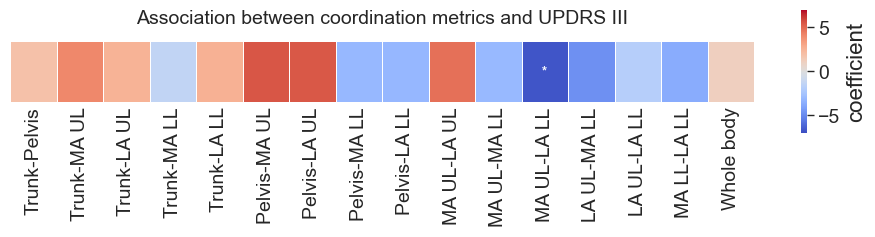

In [29]:
# --- Figure setup ---
fig, ax = plt.subplots(figsize=(12,0.8))

# Example: assuming results_df has columns like "Coefficient" and "P_Value_FDR"
# and they are DataFrames of the same shape
df_corr = pd.DataFrame(results_df["Coefficient"])

# Create annotation matrix (same shape, initially empty)
annot = pd.DataFrame("", index=df_corr.index, columns=df_corr.columns)

# Fill in significance stars for significant results

for j in range(16):   # columns
    p = results_df["P_Value"].iloc[j]  # corrected p-value
    stars = get_sigstar(p)
    if stars:  # only annotate significant
        annot.iloc[j] = stars
    else:
        annot.iloc[j] = ""

# Plot heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(
    df_corr.T,
    annot=annot.T,
    fmt="",
    cmap=cmap,
    center=0,
    # alpha = 0.75,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={"label": 'coefficient', "shrink": 2, 'aspect':20},
    vmin=-7, 
    vmax=7,
    cbar=True,
    annot_kws={"weight": "bold"},
    ax=ax
)

sns.despine(left=True, bottom=True)
# Add labels and title
# --- Title (npj-style: minimal, informative) ---
ax.set_title("Association between coordination metrics and UPDRS III", fontsize=14, pad=12)
ax.set_xlabel("", fontsize=13, labelpad=12)
ax.set_ylabel("", fontsize=13, labelpad=12)
ax.set_xticklabels(vars_coord_tot, rotation=90, fontsize=14, ha='center')
ax.set_yticklabels("", rotation=0, ha='right')
ax.tick_params(axis='both', which='both', length=0)

plt.grid(False)

os.makedirs('Figures/Supplementary/Figure S5', exist_ok=True)
fig.savefig(f"Figures/Supplementary/Figure S5/Subpane 5B_heatmap_updrs_coord.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')

plt.show()

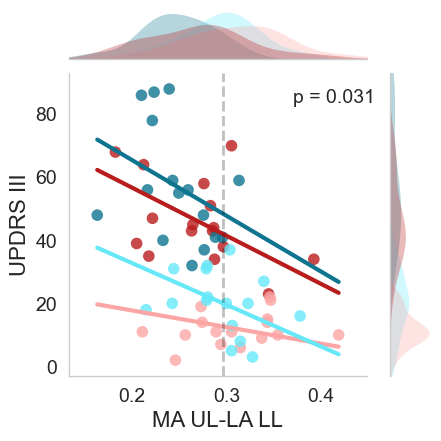

In [36]:
# Define npj-compatible style
import seaborn as sns
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})


# Xp_all_Zs = zscore(np.concatenate([X_preop_off, X_preop_on, X_postop_on, X_postop_off], axis=0))
# NON Z-SCORED FOR VISUALIZATION
Xp_all = np.concatenate([X_preop_off, X_preop_on, X_postop_on, X_postop_off], axis=0)

# for i in range(15): 
i = 11
# --- Data preparation ---
data = {
    'Participants': np.concatenate([parts_pre, parts_pre, parts_pre, parts_pre]),
    'Condition': (['OFF'] * len(updrs_off) +
                  ['ON'] * len(updrs_on) +
                  ['DBS'] * len(updrs_dbs) +
                  ['OFF DBS'] * len(updrs_off_dbs)),
    'UPDRS_III': np.concatenate([updrs_off, updrs_on, updrs_dbs, updrs_off_dbs]),
    'Coordination_Score': Xp_all[:, i]
}

df = pd.DataFrame(data)

# --- Mixed model ---
model = mixedlm('UPDRS_III ~ Coordination_Score * Condition', df, groups=df['Participants']).fit()

x_range = np.linspace(df['Coordination_Score'].min(),
                      df['Coordination_Score'].max(), 100)

pred_df = pd.DataFrame({
    'Coordination_Score': np.tile(x_range, len(df['Condition'].unique())),
    'Condition': np.repeat(df['Condition'].unique(), len(x_range))
})
pred_df['Predicted_UPDRS'] = model.predict(pred_df)

# --- Palette (two divergent pairs) ---
palette = ['#b91c1c','#fca5a5', '#67e8f9','#0e7490']  # light red, dark red, dark teal, light teal

# --- Create jointplot ---
g = sns.jointplot(
    data=df,
    x='Coordination_Score',
    y='UPDRS_III',
    hue='Condition',
    palette=palette,
    height=4.5,
    marginal_kws=dict(fill=True, alpha=0.3, linewidth=0),
    joint_kws=dict(s=70, alpha=0.8, linewidth=0),
    legend=False,
)

# --- Customize main scatter and regression lines ---
sns.lineplot(
    data=pred_df,
    x='Coordination_Score',
    y='Predicted_UPDRS',
    hue='Condition',
    palette=palette,
    ax=g.ax_joint,
    lw=3,
    legend=False,
)

# --- Healthy control mean line ---
hc_values = Xps[subj_cond_labels[:, 0] == 'HC'][:, i]
hc_mean = hc_values.mean()
g.ax_joint.axvline(hc_mean, color='black', alpha=0.25, lw=2, linestyle='--')

# --- Remove grid ---
g.ax_joint.grid(False)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)

# Optional: remove background color for marginal plots
g.ax_marg_x.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')

# --- Aesthetics ---
g.set_axis_labels(var_short[i], 'UPDRS III', fontsize=16)
g.ax_joint.tick_params(axis='both', labelsize=14)
g.ax_joint.set_xlim(df['Coordination_Score'].min() - 0.03, df['Coordination_Score'].max() + 0.03)
g.ax_joint.set_ylim(df['UPDRS_III'].min() - 5, df['UPDRS_III'].max() + 5)

# --- Clean up marginal plots ---
for ax in [g.ax_marg_x, g.ax_marg_y]:
    ax.tick_params(labelsize=14)
    ax.set_facecolor('white')

# --- Optional R² / p-value annotation ---
g.ax_joint.text(
    0.75, 0.95,
    f"p = {results_df['P_Value'][i]:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=14,
    ha='left',
    va='top',
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7)
)

# --- Final polish ---
# sns.despine(trim=True)
plt.tight_layout()

os.makedirs('Figures/Main/Figure 3', exist_ok=True)
g.savefig(f"Figures/Main/Figure 3/Subpane 3C_scatter_MAUL-LALL_updrs.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')

plt.show()

# Nested looCV LASSO

In [29]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

def rmse(y_true, y_pred, handle_nan='raise'):
    """
    Calculate Root Mean Squared Error with error handling.
    
    Parameters
    ----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    handle_nan : str, default='raise'
        How to handle NaN values: 'raise', 'ignore', or 'remove'
    
    Returns
    -------
    float
        RMSE value
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape} vs y_pred {y_pred.shape}")
    
    if handle_nan == 'remove':
        mask = ~(np.isnan(y_true) | np.isnan(y_pred))
        y_true = y_true[mask]
        y_pred = y_pred[mask]
    elif handle_nan == 'raise' and (np.isnan(y_true).any() or np.isnan(y_pred).any()):
        raise ValueError("NaN values found in input arrays")
    
    return rmse(y_true, y_pred)


In [ ]:
def get_lasso_regularization_scikit(X_inner, y_inner, parts_inner, 
                                     alpha_range=np.logspace(-3, 3, 200),
                                     plot=False, max_iter=10000, tol=1e-8):
    """
    Find optimal Lasso regularization parameter using cross-validation.
    
    Parameters
    ----------
    X_inner : array-like
        Feature matrix
    y_inner : array-like
        Target values
    parts_inner : array-like
        Partition labels for cross-validation
    alpha_range : array-like, default=np.logspace(-3, 3, 200)
        Range of alpha values to test
    plot : bool, default=False
        Whether to plot RMSE vs alpha
    max_iter : int, default=10000
        Maximum iterations for Lasso
    tol : float, default=1e-8
        Tolerance for optimization
    
    Returns
    -------
    float
        Best alpha value that minimizes mean RMSE across folds
    """
    # Validate inputs
    X_inner = np.asarray(X_inner)
    y_inner = np.asarray(y_inner)
    parts_inner = np.asarray(parts_inner)
    
    if X_inner.shape[0] != y_inner.shape[0] != parts_inner.shape[0]:
        raise ValueError("X_inner, y_inner, and parts_inner must have the same number of samples")
    
    # Initialize RMSE storage
    unique_parts = np.unique(parts_inner)
    rmse_mean = np.zeros((len(unique_parts), len(alpha_range)))
    
    # Cross-validation loop
    for ka, alpha in enumerate(alpha_range):
        for kp, part_test in enumerate(unique_parts):
            # Split data
            sel_test = (parts_inner == part_test)
            sel_train = ~sel_test
            X_train, X_test = X_inner[sel_train], X_inner[sel_test]
            y_train, y_test = y_inner[sel_train], y_inner[sel_test]
            
            # Standardize features
            scaler = StandardScaler()
            X_train_std = scaler.fit_transform(X_train)
            X_test_std = scaler.transform(X_test)
            
            # Fit Lasso and predict
            clf = Lasso(alpha=alpha, fit_intercept=True, max_iter=max_iter, tol=tol)
            clf.fit(X_train_std, y_train)
            y_pred = clf.predict(X_test_std)
            
            # Calculate RMSE
            rmse_mean[kp, ka] = rmse(y_test, y_pred)
    
    # Find best alpha
    alpha_idx = np.argmin(rmse_mean.mean(axis=0))
    best_alpha = alpha_range[alpha_idx]
    
    # Optional plotting
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(alpha_range, rmse_mean.mean(axis=0), linewidth=2)
        plt.axvline(best_alpha, color="k", linestyle="--", label=f'Best α = {best_alpha:.4f}')
        plt.xscale("log")
        plt.xlabel("Alpha (regularization strength)", fontsize=12)
        plt.ylabel("Mean RMSE across folds", fontsize=12)
        plt.title("Inner CV RMSE (Lasso)", fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return best_alpha

# Full set of variables

In [25]:
# RPC from forward gait analysis
file_path = '_df_RPCs_forward_walking.xlsx'  # Update if needed
xls = pd.ExcelFile(file_path)
df = xls.parse(xls.sheet_names[0])
vars_gi = [col for col in df.columns if col not in ['Subject','Condition']]
gi_data = {var: df[var].values for var in vars_gi}
gi_data = np.column_stack([df[var].values for var in vars_gi])
lookup_GI_data = np.column_stack((df['Condition'],df['Subject']))
subj_cond_labels_gi = np.column_stack((df['Subject'],df['Condition']))

X_pre_FW_OFF = np.zeros((len(parts_pre),gi_data.shape[1]))
X_pre_FW_ON = np.zeros((len(parts_pre),gi_data.shape[1]))

for kp,part in enumerate(parts_pre):
    
    sel_FW_off = np.all(lookup_GI_data==['OFF DOPA',part],axis=1)
    X_pre_FW_OFF[kp] = gi_data[sel_FW_off][0]

    sel_FW_on = np.all(lookup_GI_data==['ON DOPA',part],axis=1)
    X_pre_FW_ON[kp] = gi_data[sel_FW_on][0]

In [26]:
file_path = '_df_demographics.xlsx'  # Update if needed
xls = pd.ExcelFile(file_path)
df = xls.parse(xls.sheet_names[0])

vars_demo = [col for col in df.columns if col not in ['Subject','Code']]
# Convert columns to numeric (replace ',' → '.')
for var in vars_demo:
    # Convert everything to string first, replace comma, then float
    df[var] = df[var].astype(str).str.replace(',', '.', regex=False).astype(float)
data_demo_dict = {var: df[var].values for var in vars_demo}
# Stack into a numeric NumPy array
data_demo = np.column_stack([df[var].values for var in vars_demo])
# Subject labels
subj_cond_labels_demo = np.column_stack((df['Subject'].values))

X_pre_data_demo = np.zeros((len(parts_pre),data_demo.shape[1]))

for kp,part in enumerate(parts_pre):
    X_pre_data_demo[kp] = data_demo[np.all(subj_cond_labels_demo==[part],axis=0)]

In [27]:
Xps_pre_baseline = np.hstack([
                    X_pre_data_demo[:,[0,1,2]],
                    np.array(fog_pre).flatten()[:, None],                              
                    np.array(gabs_off).flatten()[:, None],
                    np.array(gabs_on).flatten()[:, None],
                    np.array(updrs_off).flatten()[:, None],
                    np.array(updrs_on).flatten()[:, None],
                    X_pre_FW_OFF, X_pre_FW_ON,
                    Xwb_off_scores,Xwb_on_scores
])

X_preop = Xps_pre_baseline

y_vals = fog_post

var_baseline= np.array([
                       'FOG PREOP',
                       'GABS OFF', 'GABS ON', 
                       'UPDRS III OFF', 'UPDRS III ON', 
                       'Pace OFF','Rhythm OFF','Balance OFF','Variability OFF','Asymmetry OFF',
                       'Pace ON','Rhythm ON','Balance ON','Variability ON','Asymmetry ON',
                       'Whole Body OFF', 'Whole Body ON'
])

vars_tot = np.hstack([vars_demo, var_baseline])

In [30]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

alpha_range = np.logspace(-5,3,200)
tol=1e-8
max_iter=10000

beta_patient = []
rmse_patient = np.zeros(len(parts_pre))
y_pred_patient = np.zeros(len(parts_pre))
best_alpha_lasso_patient = np.zeros(len(parts_pre))

for kp, part_val in enumerate(parts_pre):

    sel_val = (parts_pre == part_val)

    X_inner = X_preop[~sel_val]
    y_inner = y_vals[~sel_val]
    X_outer = X_preop[sel_val]
    y_outer = y_vals[sel_val]

    parts_inner = parts_pre[~sel_val]

    best_alpha = get_lasso_regularization_scikit(
        X_inner, y_inner, parts_inner,
        alpha_range=alpha_range,plot=False,max_iter=max_iter,tol=tol
    )

    best_alpha_lasso_patient[kp] = best_alpha

    scaler = StandardScaler()
    X_inner_std = scaler.fit_transform(X_inner)
    X_outer_std = scaler.transform(X_outer)

    clf = Lasso(alpha=best_alpha, fit_intercept=True, max_iter=max_iter,tol=tol)
    clf.fit(X_inner_std, y_inner)

    y_pred = clf.predict(X_outer_std)

    rmse_patient[kp] = rmse(y_outer, y_pred)
    y_pred_patient[kp] = y_pred[0]
    beta_patient.append(clf.coef_)

    print(part_val, rmse_patient[kp])


PD01 1.3282391939891003
PD02 2.209696619621063
PD03 4.641514859823193
PD05 4.610251339657357
PD07 3.0296006359135035
PD08 7.034854555100834
PD09 3.8685159712493284
PD10 15.680935616647023
PD11 1.3502359388863
PD12 4.342562671379268
PD13 3.2770542962590916
PD14 0.5988413453946055
PD15 1.8488787251254948
PD16 5.742034268040078
PD17 7.914052744995196
PD18 8.784288154339787


In [31]:
outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

outer rmse = 4.77 outer r2 = 0.20


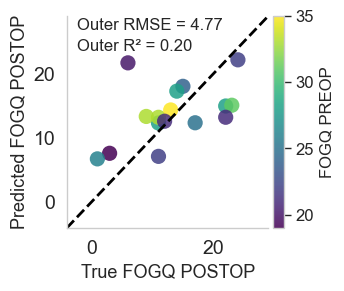

In [82]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Flatten arrays once
x = np.hstack(y_vals)
y = np.hstack(y_pred_patient)
c = np.hstack(fog_pre)

# Axis limits
lims = [
    min(x.min(), y.min()) - 5,
    max(x.max(), y.max()) + 5
]

plt.figure(figsize=(3.5, 3))
# Identity line
plt.plot(lims, lims, '--', color='black', linewidth=2)
# Main scatter
sc = plt.scatter(x, y,c=c,cmap='viridis',s=120,alpha=0.85,edgecolor='none')

# Axis formatting
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('True FOGQ POSTOP', fontsize=13)
plt.ylabel('Predicted FOGQ POSTOP', fontsize=13)

plt.text(0.05, 0.89,f'Outer R² = {outer_r2:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
plt.text(0.05, 0.99,f'Outer RMSE = {outer_rmse:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
# Colorbar
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.grid(False)

# Spines 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

os.makedirs('Figures/Main/Figure 3', exist_ok=True)
g.savefig(f"Figures/Main/Figure 3/Subpane 3D_scatter_true_predicted_FULL.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

In [33]:
mean_coefs = np.mean(beta_patient,axis=0)
std_coefs =  np.std(beta_patient,axis=0)
order_vars = np.argsort(np.abs(mean_coefs))
freq_coef = np.count_nonzero(beta_patient,axis=0)/X_preop.shape[0]

df_model_ = pd.DataFrame({
    "variable": vars_tot,
    "frequency_coef": freq_coef,
    "mean_coef": mean_coefs,
    "std_coef": std_coefs
})
df_model_

variable  frequency_coef  mean_coef  std_coef
0                Age          0.6875   0.848283  0.818595
1                BMI          0.1250  -0.147823  0.402270
2   Disease Duration          0.1250  -0.129162  0.395195
3          FOG PREOP          0.1875  -0.075773  0.220022
4           GABS OFF          0.0625   0.076783  0.297380
5            GABS ON          1.0000   2.188205  0.783155
6      UPDRS III OFF          0.8125  -0.672133  0.564568
7       UPDRS III ON          0.1875  -0.237478  0.618349
8           Pace OFF          0.4375  -0.418785  0.829297
9         Rhythm OFF          0.0625  -0.058889  0.228074
10       Balance OFF          0.3125   0.066040  0.171063
11   Variability OFF          0.1250  -0.038178  0.147775
12     Asymmetry OFF          0.4375   0.289650  0.489279
13           Pace ON          0.1250   0.274247  0.840367
14         Rhythm ON          0.1250   0.002383  0.008912
15        Balance ON          0.1875   0.104371  0.319709
16    Variability ON          0.1250   0.037438  0.207096
17      Asymmetry ON          0.1250   0.067651  0.274423
18    Whole Body OFF          1.0000   3.223580  0.604080
19     Whole Body ON          0.2500   0.110533  0.233540

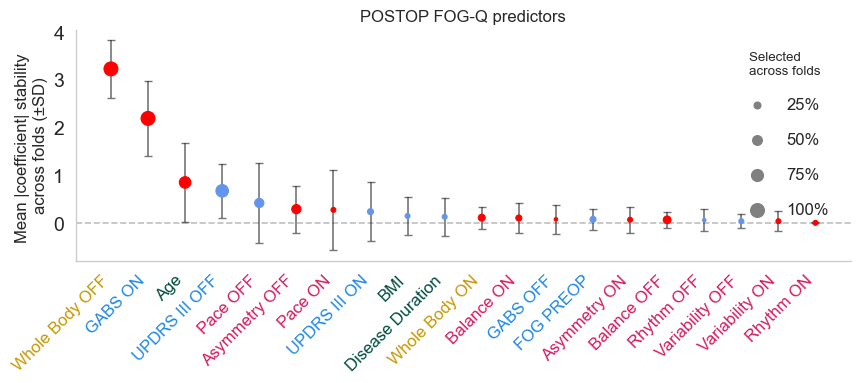

In [34]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Define color mappings upfront
CATEGORY_COLORS = {
    'Gait domains': "#D81B60",
    'Clinical': "#1E88E5", 
    'Coordination': "#CA9700",
    'Demographics': "#004D40"
}

# Map each variable index to its category (replace with your actual categories)
label_categories = {
    0: 'Coordination', 1: 'Clinical', 2: 'Demographics', 3: 'Clinical',
    4: 'Gait domains', 5: 'Gait domains', 6: 'Gait domains', 7: 'Clinical',
    8: 'Demographics', 9: 'Demographics', 10: 'Coordination', 11: 'Gait domains',
    12: 'Clinical', 13: 'Clinical', 14: 'Gait domains', 15: 'Gait domains',
    16: 'Gait domains', 17: 'Gait domains', 18: 'Gait domains', 19: 'Gait domains'
}

order_vars = np.argsort(np.abs(mean_coefs))[::-1]

plt.figure(figsize=(10,3))
colors = np.where(mean_coefs[order_vars] >= 0, 'red', '#6495ed')
plt.scatter(np.arange(len(mean_coefs)),np.abs(mean_coefs)[order_vars],s=100*freq_coef[order_vars], zorder=2, color = colors)
plt.errorbar(np.arange(len(mean_coefs)),np.abs(mean_coefs)[order_vars],yerr = std_coefs[order_vars], capsize = 3, alpha =.6,
             marker='o',fmt='none',ecolor = 'k', zorder=1)

plt.xticks(np.arange(len(mean_coefs)),vars_tot[order_vars], fontsize = 12, rotation = 45, ha = 'right')
plt.axhline(0,c='gray',ls='--',alpha= .5,zorder=0)
plt.ylabel('Mean |coefficient| stability \nacross folds (±SD)', fontsize = 12)
plt.title('POSTOP FOG-Q predictors', fontsize = 12)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Color x-tick labels by category
for idx, label in enumerate(ax.get_xticklabels()):
    category = label_categories.get(idx, 'clinical')
    label.set_color(CATEGORY_COLORS[category])
    
plt.grid(False)
# Choose reference frequencies you want to show
freq_levels = [25, 50, 75, 100]
legend_sizes = [f for f in freq_levels]
handles = [
    plt.scatter([], [], s=s, color='gray')#, edgecolors='k'
    for s in legend_sizes
]
labels = [f"{f}%" for f in freq_levels]
plt.legend(
    handles,
    labels,
    title="Selected \nacross folds",
    scatterpoints=1,
    frameon=False,
    labelspacing=1.2,
    borderpad=0.8,
    loc = 'upper right'
)
os.makedirs('Figures/Main/Figure 3', exist_ok=True)
g.savefig(f"Figures/Main/Figure 3/Subpane 3D_stability_coeff_FULL.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

## Model excluding RPCs from the full set of baseline variables

In [42]:
Xps_pre_baseline = np.hstack([
                    X_pre_data_demo[:,[0,1,2]],
                    np.array(fog_pre).flatten()[:, None],                              
                    np.array(gabs_off).flatten()[:, None],
                    np.array(gabs_on).flatten()[:, None],
                    np.array(updrs_off).flatten()[:, None],
                    np.array(updrs_on).flatten()[:, None],
                    # X_pre_FW_OFF, X_pre_FW_ON,
                    Xwb_off_scores,Xwb_on_scores
])

X_preop = Xps_pre_baseline

y_vals = fog_post

var_baseline= np.array([
                       'FOG PREOP',
                       'GABS OFF', 'GABS ON', 
                       'UPDRS III OFF', 'UPDRS III ON', 
                       # 'Pace OFF','Rhythm OFF','Balance OFF','Variability OFF','Asymmetry OFF',
                       # 'Pace ON','Rhythm ON','Balance ON','Variability ON','Asymmetry ON',
                       'Whole Body OFF', 'Whole Body ON'
])

vars_tot = np.hstack([vars_demo, var_baseline])

In [43]:
alpha_range = np.logspace(-5,3,200)
tol=1e-8
max_iter=10000

beta_patient = []
rmse_patient = np.zeros(len(parts_pre))
y_pred_patient = np.zeros(len(parts_pre))
best_alpha_lasso_patient = np.zeros(len(parts_pre))

for kp, part_val in enumerate(parts_pre):

    sel_val = (parts_pre == part_val)

    X_inner = X_preop[~sel_val]
    y_inner = y_vals[~sel_val]
    X_outer = X_preop[sel_val]
    y_outer = y_vals[sel_val]

    parts_inner = parts_pre[~sel_val]

    best_alpha = get_lasso_regularization_scikit(
        X_inner, y_inner, parts_inner,
        alpha_range=alpha_range,plot=False,max_iter=max_iter,tol=tol
    )

    best_alpha_lasso_patient[kp] = best_alpha

    scaler = StandardScaler()
    X_inner_std = scaler.fit_transform(X_inner)
    X_outer_std = scaler.transform(X_outer)

    clf = Lasso(alpha=best_alpha, fit_intercept=True, max_iter=max_iter,tol=tol)
    clf.fit(X_inner_std, y_inner)

    y_pred = clf.predict(X_outer_std)

    rmse_patient[kp] = rmse(y_outer, y_pred)
    y_pred_patient[kp] = y_pred[0]
    beta_patient.append(clf.coef_)

    print(part_val, rmse_patient[kp])

PD01 0.03785232989309151
PD02 1.6655427515006078
PD03 3.47341339671995
PD05 1.8286360937075088
PD07 3.453178162931785
PD08 3.753147024961521
PD09 3.72066548232653
PD10 2.18929152149682
PD11 0.7549717296452645
PD12 4.443653510293798
PD13 2.895726269132016
PD14 2.477451600299748
PD15 3.728610034516759
PD16 5.442848112416855
PD17 7.932126292184552
PD18 6.613304215143776


In [44]:
outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

outer rmse = 3.40 outer r2 = 0.66


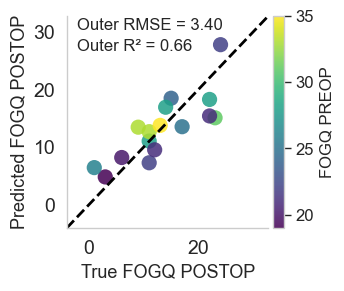

In [89]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Flatten arrays once
x = np.hstack(y_vals)
y = np.hstack(y_pred_patient)
c = np.hstack(fog_pre)

# Axis limits
lims = [
    min(x.min(), y.min()) - 5,
    max(x.max(), y.max()) + 5
]

# Identify extreme points
# idx_max = np.argmax(y)
idx_min = np.argmin(y)

plt.figure(figsize=(3.5, 3))
# Identity line
plt.plot(lims, lims, '--', color='black', linewidth=2)
# Main scatter
sc = plt.scatter(x, y,c=c,cmap='viridis',s=120,alpha=0.85,edgecolor='none')
# Highlight max / min prediction
# plt.scatter(x[idx_max], y[idx_max],s=260, facecolor='none',edgecolor='red', linewidth=2,label='Max predicted')
# plt.scatter(x[idx_min], y[idx_min],s=260, facecolor='none',edgecolor='#00a6c7', linewidth=2,label='Min predicted')
# Axis formatting
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('True FOGQ POSTOP', fontsize=13)
plt.ylabel('Predicted FOGQ POSTOP', fontsize=13)

plt.text(0.05, 0.89,f'Outer R² = {outer_r2:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
plt.text(0.05, 0.99,f'Outer RMSE = {outer_rmse:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
# Colorbar
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Ticks
# plt.xticks(fontsize=9)
# plt.yticks(fontsize=9)
plt.grid(False)
# Spines 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
os.makedirs('Figures/Supplementary/Figure S6', exist_ok=True)
g.savefig(f"Figures/Supplementary/Figure S6/_scatter_true_predicted_noRPCs.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

In [45]:
mean_coefs = np.mean(beta_patient,axis=0)
std_coefs =  np.std(beta_patient,axis=0)
order_vars = np.argsort(np.abs(mean_coefs))
freq_coef = np.count_nonzero(beta_patient,axis=0)/X_preop.shape[0]

df_model_ = pd.DataFrame({
    "variable": vars_tot,
    "frequency_coef": freq_coef,
    "mean_coef": mean_coefs,
    "std_coef": std_coefs
})
df_model_

variable  frequency_coef  mean_coef  std_coef
0               Age          1.0000   0.928907  0.284959
1               BMI          0.0000   0.000000  0.000000
2  Disease Duration          0.0000   0.000000  0.000000
3         FOG PREOP          0.1250  -0.064399  0.170384
4          GABS OFF          0.2500   0.128901  0.296294
5           GABS ON          1.0000   2.682207  0.534207
6     UPDRS III OFF          1.0000  -1.047620  0.275086
7      UPDRS III ON          0.2500  -0.121267  0.228221
8    Whole Body OFF          1.0000   3.498886  0.351226
9     Whole Body ON          0.3125   0.176698  0.305643

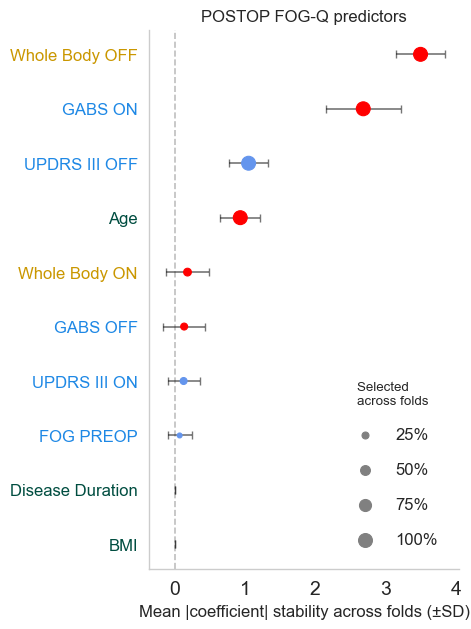

In [46]:
# Define color mappings upfront
CATEGORY_COLORS = {
    'Gait domains': "#D81B60",
    'Clinical': "#1E88E5", 
    'Coordination': "#CA9700",
    'Demographics': "#004D40"
}

# Map each variable index to its category (replace with your actual categories)
label_categories = {
    0: 'Demographics',    1: 'Demographics',    2: 'Clinical',    3: 'Clinical',
    4: 'Clinical',    5: 'Coordination',    6: 'Demographics',    7: 'Clinical',    8: 'Clinical',    9: 'Coordination'
}

plt.figure(figsize=(4,7))
colors = np.where(mean_coefs[order_vars] >= 0, 'red', '#6495ed')
plt.scatter(np.abs(mean_coefs)[order_vars],np.arange(len(mean_coefs)),s=100*freq_coef[order_vars], zorder=2, color = colors)
plt.errorbar(np.abs(mean_coefs)[order_vars],np.arange(len(mean_coefs)),xerr = std_coefs[order_vars], capsize = 3, alpha =.6,
             marker='o',fmt='none',ecolor = 'k', zorder=1)
plt.yticks(np.arange(len(mean_coefs)),vars_tot[order_vars], fontsize = 12)
plt.axvline(0,c='gray',ls='--',alpha= .5,zorder=0)
plt.xlabel('Mean |coefficient| stability across folds (±SD)', fontsize = 12)
plt.title('POSTOP FOG-Q predictors', fontsize = 12)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Color y-tick labels by category
for idx, label in enumerate(ax.get_yticklabels()):
    category = label_categories.get(idx, 'clinical')  # default to clinical if not specified
    label.set_color(CATEGORY_COLORS[category])

    
# Choose reference frequencies you want to show
freq_levels = [25, 50, 75, 100]
legend_sizes = [f for f in freq_levels]
handles = [
    plt.scatter([], [], s=s, color='gray')#, edgecolors='k'
    for s in legend_sizes
]
labels = [f"{f}%" for f in freq_levels]
plt.legend(
    handles,
    labels,
    title="Selected \nacross folds",
    scatterpoints=1,
    frameon=False,
    labelspacing=1.2,
    borderpad=0.8,
    loc = 'lower right'
)
plt.grid(False)
os.makedirs('Figures/Supplementary/Figure S6', exist_ok=True)
g.savefig(f"Figures/Supplementary/Figure S6/_stability_coeff_noRPCs.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

## Model including body segment coordinations only

In [92]:
Xps_pre = np.hstack([Xp_on_scores,Xp_off_scores])

y_vals = fog_post
X_preop = Xps_pre

In [93]:
alpha_range = np.logspace(-5,3,200)
tol=1e-8
max_iter=10000

beta_patient = []
rmse_patient = np.zeros(len(parts_pre))
y_pred_patient = np.zeros(len(parts_pre))
best_alpha_lasso_patient = np.zeros(len(parts_pre))

for kp, part_val in enumerate(parts_pre):

    sel_val = (parts_pre == part_val)

    X_inner = X_preop[~sel_val]
    y_inner = y_vals[~sel_val]
    X_outer = X_preop[sel_val]
    y_outer = y_vals[sel_val]

    parts_inner = parts_pre[~sel_val]

    best_alpha = get_lasso_regularization_scikit(
        X_inner, y_inner, parts_inner,
        alpha_range=alpha_range,plot=False,max_iter=max_iter,tol=tol
    )

    best_alpha_lasso_patient[kp] = best_alpha

    scaler = StandardScaler()
    X_inner_std = scaler.fit_transform(X_inner)
    X_outer_std = scaler.transform(X_outer)

    clf = Lasso(alpha=best_alpha, fit_intercept=True, max_iter=max_iter,tol=tol)
    clf.fit(X_inner_std, y_inner)

    y_pred = clf.predict(X_outer_std)

    rmse_patient[kp] = rmse(y_outer, y_pred)
    y_pred_patient[kp] = y_pred[0]
    beta_patient.append(clf.coef_)

    print(part_val, rmse_patient[kp])

PD01 2.2646260711244217
PD02 1.6690415929628735
PD03 2.585071128227842
PD05 1.2013471638448596
PD07 0.6903278493088827
PD08 3.4127735143610742
PD09 1.7398810616485996
PD10 3.8833151276430513
PD11 2.1425995205095596
PD12 4.729677786807827
PD13 0.2833602691006689
PD14 2.308725342401118
PD15 0.5695176933649897
PD16 11.66145589217862
PD17 17.533001027883778
PD18 1.9394881812043963


In [94]:
outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

outer rmse = 3.66 outer r2 = 0.27


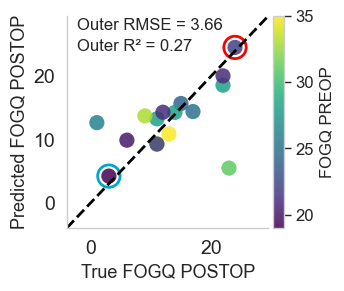

In [95]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

# Flatten arrays once
x = np.hstack(y_vals)
y = np.hstack(y_pred_patient)
c = np.hstack(fog_pre)

# Axis limits
lims = [
    min(x.min(), y.min()) - 5,
    max(x.max(), y.max()) + 5
]

# Identify extreme points
idx_max = np.argmax(y)
idx_min = np.argmin(y)

plt.figure(figsize=(3.5, 3))
# Identity line
plt.plot(lims, lims, '--', color='black', linewidth=2)
# Main scatter
sc = plt.scatter(x, y, c=c,cmap='viridis',s=120,alpha=0.85,edgecolor='none')
# Highlight max / min prediction
plt.scatter(x[idx_max], y[idx_max],s=260, facecolor='none',edgecolor='red', linewidth=2,label='Min improved')
plt.scatter(x[idx_min], y[idx_min],s=260, facecolor='none',edgecolor='#00a6c7', linewidth=2,label='Max imporved')
# Axis formatting
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel('True FOGQ POSTOP', fontsize=13)
plt.ylabel('Predicted FOGQ POSTOP', fontsize=13)

plt.text(0.05, 0.89,f'Outer R² = {outer_r2:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
plt.text(0.05, 0.99,f'Outer RMSE = {outer_rmse:.2f}',transform=plt.gca().transAxes,fontsize=12,verticalalignment='top')
# Colorbar
cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Ticks
# plt.xticks(fontsize=9)
# plt.yticks(fontsize=9)
plt.grid(False)

# Spines 
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

os.makedirs('Figures/Main/Figure 4', exist_ok=True)
g.savefig(f"Figures/Main/Figure 4/_scatter_true_predicted_segmental_coord.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')

plt.show()

In [96]:
var_short_new = []
for var in var_short:
    var_short_new.append(var+ ' ON')
for var in var_short:
    var_short_new.append(var+ ' OFF')
var_short_new = np.array(var_short_new)

mean_coefs = np.mean(beta_patient,axis=0)
std_coefs =  np.std(beta_patient,axis=0)
freq_coef = np.count_nonzero(beta_patient,axis=0)/X_preop.shape[0]

df_model_ = pd.DataFrame({
    "variable": var_short_new,
    "frequency_coef": freq_coef,
    "mean_coef": mean_coefs,
    "std_coef": std_coefs
})
df_model_

variable  frequency_coef  mean_coef  std_coef
0    Trunk-Pelvis ON          0.9375  -3.223147  0.907076
1     Trunk-MA UL ON          0.1875  -0.006336  0.037478
2     Trunk-LA UL ON          0.0625   0.049879  0.193180
3     Trunk-MA LL ON          0.0625  -0.005867  0.022723
4     Trunk-LA LL ON          0.1875   0.039577  0.086992
5    Pelvis-MA UL ON          0.0625  -0.015987  0.061919
6    Pelvis-LA UL ON          0.1875   0.115559  0.435819
7    Pelvis-MA LL ON          0.3750  -0.193591  0.454837
8    Pelvis-LA LL ON          1.0000  -1.771520  0.384207
9     MA UL-LA UL ON          0.1250   0.003938  0.043536
10    MA UL-MA LL ON          0.1250  -0.039788  0.156477
11    MA UL-LA LL ON          0.1875   0.004217  0.094839
12    LA UL-MA LL ON          0.1250   0.038732  0.242084
13    LA UL-LA LL ON          0.1875   0.024523  0.054917
14    MA LL-LA LL ON          0.0625   0.058533  0.226698
15  Trunk-Pelvis OFF          1.0000   2.920224  0.911329
16   Trunk-MA UL OFF          0.0625   0.017942  0.069488
17   Trunk-LA UL OFF          0.0625   0.138733  0.537309
18   Trunk-MA LL OFF          0.1875   0.063879  0.193438
19   Trunk-LA LL OFF          0.0625   0.045413  0.175885
20  Pelvis-MA UL OFF          0.0625   0.069785  0.270277
21  Pelvis-LA UL OFF          0.1250   0.041273  0.136625
22  Pelvis-MA LL OFF          1.0000   4.068493  0.552866
23  Pelvis-LA LL OFF          0.0625   0.000954  0.003693
24   MA UL-LA UL OFF          0.0625  -0.015429  0.059755
25   MA UL-MA LL OFF          0.0000   0.000000  0.000000
26   MA UL-LA LL OFF          0.0625  -0.132912  0.514765
27   LA UL-MA LL OFF          0.0000   0.000000  0.000000
28   LA UL-LA LL OFF          0.0000   0.000000  0.000000
29   MA LL-LA LL OFF          0.0000   0.000000  0.000000

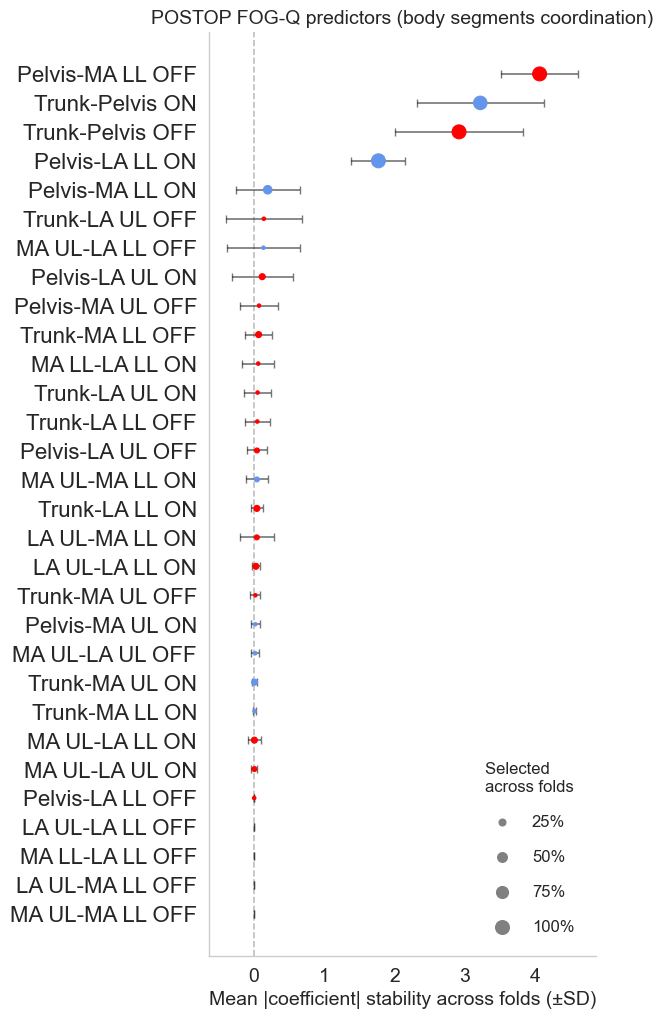

In [97]:
order_vars = np.argsort(np.abs(mean_coefs))

plt.figure(figsize=(5,12))
colors = np.where(mean_coefs[order_vars] >= 0, 'red', '#6495ed')
y_positions = np.arange(len(mean_coefs)) * 2  # increase spacing

plt.scatter(np.abs(mean_coefs)[order_vars],y_positions,s=100*freq_coef[order_vars], zorder=2, color = colors)
plt.errorbar(np.abs(mean_coefs)[order_vars],y_positions,xerr = std_coefs[order_vars], capsize = 3, alpha =.6,
             marker='o',fmt='none',ecolor = 'k', zorder=1)


plt.yticks(y_positions,var_short_new[order_vars], fontsize = 16)
plt.xticks(fontsize=14)

plt.axvline(0,c='gray',ls='--',alpha= .5,zorder=0)
plt.xlabel('Mean |coefficient| stability across folds (±SD)', fontsize = 14)
plt.title('POSTOP FOG-Q predictors (body segments coordination)', fontsize = 14)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Choose reference frequencies you want to show
freq_levels = [25, 50, 75, 100]
legend_sizes = [f for f in freq_levels]
handles = [
    plt.scatter([], [], s=s, color='gray')#, edgecolors='k'
    for s in legend_sizes
]
labels = [f"{f}%" for f in freq_levels]
plt.legend(
    handles,
    labels,
    title="Selected \nacross folds", 
    title_fontsize = 12,
    scatterpoints=1,
    frameon=False,
    labelspacing=1.2,
    borderpad=0.8,
    fontsize = 12,
    loc = 'lower right'
)

plt.grid(False)
os.makedirs('Figures/Main/Figure 4', exist_ok=True)
g.savefig(f"Figures/Main/Figure 4/_stability_coeff_segmental_coord.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

# Aggregated variables

## Trunk - pelvis - Lower limbs

In [100]:
cax = []
var_labels = []

# Define cluster sets you want
cluster_sets = [[1,2,5,6]]

# Get indices for each set
indices_clusters = [np.concatenate([np.where(clusters == c)[0] for c in clist]) 
                    for clist in cluster_sets]

# Loop over cluster sets
for idx, idx_cluster in enumerate(indices_clusters):
    c_cond_trial = []
    for k in range(len(C_a_subj_cond)):
        cax_trial = []
        for i in range(len(C_a_subj_cond[k])):
            # Mean connectivity within this cluster set
            # cmean = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[idx_cluster, :][:, idx_cluster].sum()
            submatax = np.abs(C_a_subj_cond[k][i]).mean(axis=2)[idx_cluster, :][:, idx_cluster]
            caxmean = np.triu(submatax, k=1).mean()
            cax_trial.append(caxmean)  
        c_cond_trial.append(np.hstack(cax_trial).mean())
  
    cax.append(np.hstack(c_cond_trial))
    var_labels.append(cluster_sets[idx])
    
print(var_labels)

var_ax = ['Trunk - Pelvis - Lower Limbs']

Xax = np.array(cax).T

Xax_on_scores= np.zeros((len(parts_pre),Xax.shape[1]))
Xax_off_scores= np.zeros((len(parts_pre),Xax.shape[1]))
Xax_on_dbs_scores = np.zeros((len(parts_pre),Xax.shape[1]))
Xax_off_dbs_scores = np.zeros((len(parts_pre),Xax.shape[1]))


for kp,part in enumerate(parts_pre):
    sel_kin_on = np.all(subj_cond_labels==['ON DOPA',part],axis=1)
    Xax_on_scores[kp] = Xax[sel_kin_on]

    sel_kin_off = np.all(subj_cond_labels==['OFF DOPA',part],axis=1)
    Xax_off_scores[kp] = Xax[sel_kin_off]

    sel_kin_on_dbs = np.all(subj_cond_labels==['ON DBS',part],axis=1)
    Xax_on_dbs_scores[kp] = Xax[sel_kin_on_dbs]

    sel_kin_off_dbs = np.all(subj_cond_labels==['OFF DBS',part],axis=1)
    Xax_off_dbs_scores[kp] = Xax[sel_kin_off_dbs]

[[1, 2, 5, 6]]


In [101]:
def leave_one_patient_out_linear_model(X,y,parts,scale=True):
    """
    Leave-one-patient-out linear regression (OLS)

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target values
    parts : array-like, shape (n_samples,)
        Patient/group labels
    scale : bool, default=True
        Whether to standardize features

    Returns
    -------
    y_pred_patient : np.ndarray, shape (n_patients,)
        Prediction for each left-out patient
    rmse_patient : np.ndarray, shape (n_patients,)
        RMSE for each patient
    beta_patient : list of np.ndarray
        Regression coefficients for each fold
    """

    unique_parts = np.unique(parts)

    y_pred_patient = np.zeros(len(unique_parts))
    rmse_patient = np.zeros(len(unique_parts))
    beta_patient = []

    for kp, part_val in enumerate(unique_parts):

        sel_val = (parts == part_val)

        X_inner = X[~sel_val]
        y_inner = y[~sel_val]
        X_outer = X[sel_val]
        y_outer = y[sel_val]

        if scale:
            scaler = StandardScaler()
            X_inner = scaler.fit_transform(X_inner)
            X_outer = scaler.transform(X_outer)

        clf = LinearRegression(fit_intercept=True)
        clf.fit(X_inner, y_inner)

        y_pred = clf.predict(X_outer)

        y_pred_patient[kp] = np.mean(y_pred)
        rmse_patient[kp] = rmse(y_outer, y_pred)
        beta_patient.append(clf.coef_)

    return y_pred_patient, rmse_patient, beta_patient

In [104]:
from sklearn.linear_model import LinearRegression

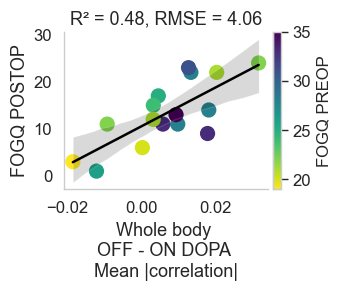

In [106]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


y_vals = fog_post
X_preop = Xwb_off_scores-Xwb_on_scores
y_pred_patient, rmse_patient, beta_patient = leave_one_patient_out_linear_model(X_preop,y_vals,parts_pre,scale=True)

outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
# print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

plt.figure(figsize=(3.5,3))

# Color points by fog_post
# plt.axvline(hc_mean, color='black', ls = '--', alpha=0.3)
sc = plt.scatter(x=X_preop, y=y_vals, c=fog_pre, cmap="viridis_r", s=120, edgecolor='none')

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# Add regression line (not color-coded)
sns.regplot(x=X_preop, y=y_vals, scatter=False, ci=95, line_kws={"color":"black"})

plt.title(f"R² = {outer_r2:.2f}, RMSE = {outer_rmse:.2f}", fontsize = 13)
    
plt.ylabel("FOGQ POSTOP", fontsize = 13)
plt.xlabel(f"{var_wb[0]} \nOFF - ON DOPA \nMean |correlation|", fontsize = 13)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

sns.despine(right=True, top=True)
plt.tight_layout()

plt.grid(False)

os.makedirs('Figures/Main/Figure 5', exist_ok=True)
g.savefig(f"Figures/Main/Figure 5/Subpane A_left.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')

plt.show()

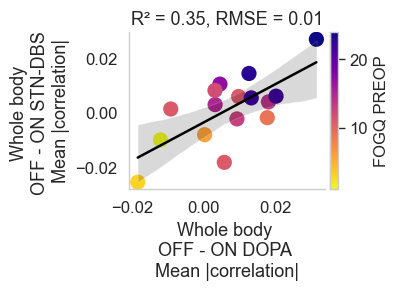

In [107]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


y_vals = Xwb_off_scores-Xwb_on_dbs_scores
X_preop = Xwb_off_scores-Xwb_on_scores

y_pred_patient, rmse_patient, beta_patient = leave_one_patient_out_linear_model(X_preop,y_vals,parts_pre,scale=True)

outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
# print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

plt.figure(figsize=(4,3))

# Color points by fog_post
# plt.axvline(hc_mean, color='black', ls = '--', alpha=0.3)
sc = plt.scatter(x=X_preop, y=y_vals, c=fog_post, cmap="plasma_r", s=120, edgecolor='none')

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# Add regression line (not color-coded)
sns.regplot(x=X_preop, y=y_vals, scatter=False, ci=95, line_kws={"color":"black"})

plt.title(f"R² = {outer_r2:.2f}, RMSE = {outer_rmse:.2f}", fontsize = 13)
    
plt.ylabel(f"{var_wb[0]} \nOFF - ON STN-DBS \nMean |correlation|", fontsize = 13)
plt.xlabel(f"{var_wb[0]} \nOFF - ON DOPA \nMean |correlation|", fontsize = 13)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

sns.despine(right=True, top=True)
plt.tight_layout()

plt.grid(False)
os.makedirs('Figures/Main/Figure 5', exist_ok=True)
g.savefig(f"Figures/Main/Figure 5/Subpane B_left.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

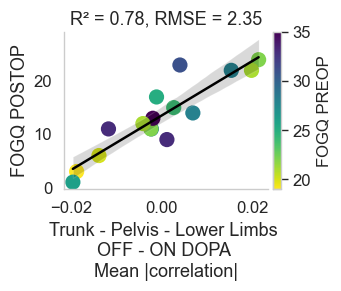

In [108]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


y_vals = fog_post
X_preop = Xax_off_scores-Xax_on_scores
y_pred_patient, rmse_patient, beta_patient = leave_one_patient_out_linear_model(X_preop,y_vals,parts_pre,scale=True)

outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
# print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

plt.figure(figsize=(3.5,3))

# Color points by fog_post
# plt.axvline(hc_mean, color='black', ls = '--', alpha=0.3)
sc = plt.scatter(x=X_preop, y=y_vals, c=fog_pre, cmap="viridis_r", s=120, edgecolor='none')

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# Add regression line (not color-coded)
sns.regplot(x=X_preop, y=y_vals, scatter=False, ci=95, line_kws={"color":"black"})

plt.title(f"R² = {outer_r2:.2f}, RMSE = {outer_rmse:.2f}", fontsize = 13)
    
plt.ylabel("FOGQ POSTOP", fontsize = 13)
plt.xlabel(f"{var_ax[0]} \nOFF - ON DOPA \nMean |correlation|", fontsize = 13)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ PREOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

sns.despine(right=True, top=True)
plt.tight_layout()

plt.grid(False)
os.makedirs('Figures/Main/Figure 5', exist_ok=True)
g.savefig(f"Figures/Main/Figure 5/Subpane A_right.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()

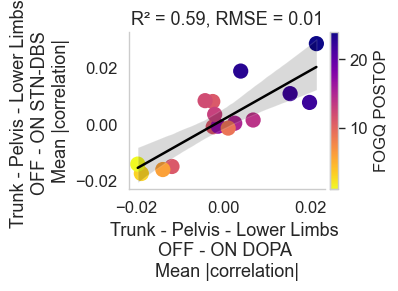

In [109]:
sns.set_theme(context="paper", style="whitegrid", font="Arial")
plt.rcParams.update({
    "axes.linewidth": 1,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})


y_vals = Xax_off_scores-Xax_on_dbs_scores
X_preop = Xax_off_scores-Xax_on_scores
y_pred_patient, rmse_patient, beta_patient = leave_one_patient_out_linear_model(X_preop,y_vals,parts_pre,scale=True)

outer_r2 = r2_score(y_vals,y_pred_patient)
outer_rmse = rmse_patient.mean()
# print('outer rmse = {:.2f}'.format(outer_rmse),'outer r2 = {:.2f}'.format(outer_r2))

plt.figure(figsize=(4,3))

# Color points by fog_post
# plt.axvline(hc_mean, color='black', ls = '--', alpha=0.3)
sc = plt.scatter(x=X_preop, y=y_vals, c=fog_post, cmap="plasma_r", s=120, edgecolor='none')

# ax.spines["right"].set_visible(False)
# ax.spines["top"].set_visible(False)
# Add regression line (not color-coded)
sns.regplot(x=X_preop, y=y_vals, scatter=False, ci=95, line_kws={"color":"black"})

plt.title(f"R² = {outer_r2:.2f}, RMSE = {outer_rmse:.2f}", fontsize = 13)
    
plt.ylabel(f"{var_ax[0]} \nOFF - ON STN-DBS \nMean |correlation|", fontsize = 13)
plt.xlabel(f"{var_ax[0]} \nOFF - ON DOPA \nMean |correlation|", fontsize = 13)

cbar = plt.colorbar(sc, pad=0.02)
cbar.set_label('FOGQ POSTOP', fontsize=12)
cbar.ax.tick_params(labelsize=12)

sns.despine(right=True, top=True)
plt.tight_layout()

plt.grid(False)
os.makedirs('Figures/Main/Figure 5', exist_ok=True)
g.savefig(f"Figures/Main/Figure 5/Subpane B_right.svg", 
        dpi=1000, bbox_inches="tight", facecolor = 'white')
plt.show()